## Supervised machine learning

Having explored some unsupervised machine learning methods yesterday, we will move on to supervised techniques. Supervised learning is the task of finding a mapping from input data to output labels based on example input-output pairs. During the training (or fitting) phase, the model builds an internal function which maps input to output, ideally in a way that can be generalized to unseen data successfully. Once a model is trained, it can be used to predict output labels from the input data alone.

They come in two main groups: classifiers for categorical labels, and regressors for continuous numeric labels.

Our first dataset will be the mice gene expression data on the input side, and the categorical diet labels on the output (or target) side. The first supervised model that we will train and evaluate will be a support vector classifier.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
import sklearn.model_selection as sm

In [2]:
xls = pd.read_excel('files/S5.xlsx', header=2)


In [3]:
expr = xls.groupby('Gene.1').mean()  # or 'Gene' if you had used that for your DE calculations
expr = expr.loc[:, expr.columns.str.contains('Liver')]
is_hfd = pd.Series(expr.columns.str.contains('HFD'), index=expr.columns)  # diet labels for verification

data = expr.T    # let's use the name 'data' for input
target = 1*is_hfd  # let's use the name 'target' for the labels / expected outputs. For simplicity, use 1/0 instead of True/False


## Task 1: Create a support vector classifier using a linear kernel

### 1.1 Train it with the whole dataset

In [4]:
#There is the vanilla SVC with the kernel="lin" option, but we decided to give the LinearSVC a try
clf = LinearSVC(random_state=0)
clf.fit(data, target)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)

### 1.2 Evaluate its accuracy on the training data
We are asking you to commit a **mortal sin**: evaluate a machine learning algorithm on the same data that you had trained it with. But do it anyway. Are you surprised by its accuracy?

In [5]:
clf.score(data, target)

1.0

100% accuracy, best predictor EVER. This is was someone who tries to evaluate with the traning data hast to expect.

### 1.3 Compare the support vector with the 4 component vectors from yesterday's PCA
To save you the trouble of moving code between sheets, we provided you the PCA code below.

Find a suitable way of comparing them, and discuss what you found.

In [6]:
pca = PCA(n_components=4)
pca.fit(data)

#Merge the four pca vectors with the support vector
coeffs = pd.DataFrame(pca.components_, index=['pc1', 'pc2', 'pc3', 'pc4']).T

coeffs['support_vector'] = clf.coef_.T
coeffs.head()


,pc1,pc2,pc3,pc4,support_vector
0,0.000871,-0.002130,-0.000766,0.000226,0.000149
1,0.009557,0.010204,-0.001158,-0.006339,0.000304
2,-0.001060,-0.003915,0.001955,-0.004805,0.000078
3,-0.002615,-0.003060,-0.002534,-0.000280,0.000047
4,0.003394,0.003273,-0.006968,0.000349,0.000250


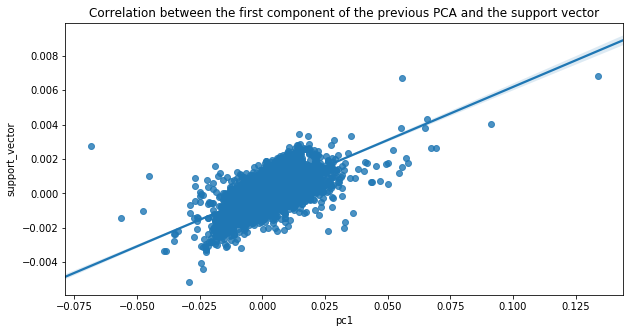

In [7]:
#Plot first component against the support vector

fig, ax = plt.subplots(figsize=(10,5))
plt.title('Correlation between the first component of the previous PCA and the support vector')
sns.regplot(x=coeffs['pc1'], y=coeffs['support_vector'])
plt.show()

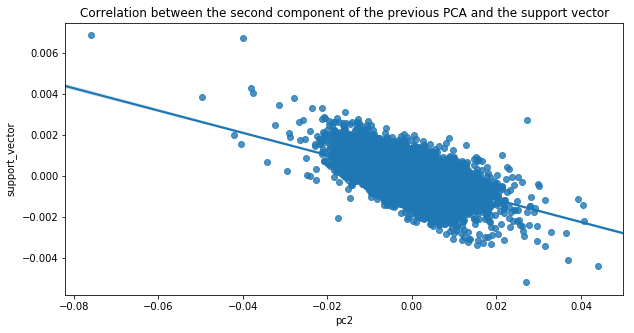

In [8]:
#Plot second component against the support vector

fig, ax = plt.subplots(figsize=(10,5))
plt.title('Correlation between the second component of the previous PCA and the support vector')
sns.regplot(x=coeffs['pc2'], y=coeffs['support_vector'])
plt.show()

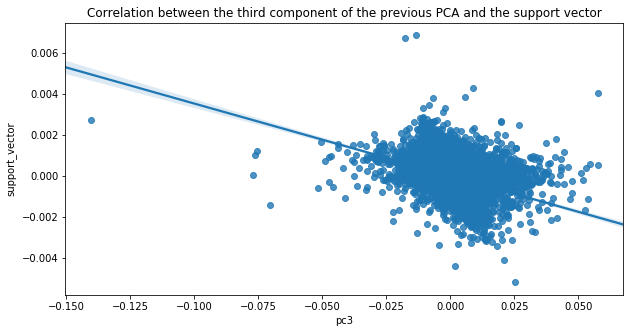

In [9]:
#Plot third component against the support vector

fig, ax = plt.subplots(figsize=(10,5))
plt.title('Correlation between the third component of the previous PCA and the support vector')
sns.regplot(x=coeffs['pc3'], y=coeffs['support_vector'])
plt.show()

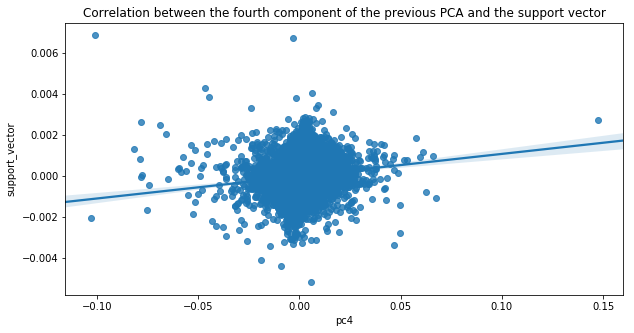

In [10]:
#Plot fourth component against the support vector

fig, ax = plt.subplots(figsize=(10,5))
plt.title('Correlation between the fourth component of the previous PCA and the support vector')
sns.regplot(x=coeffs['pc4'], y=coeffs['support_vector'])
plt.show()

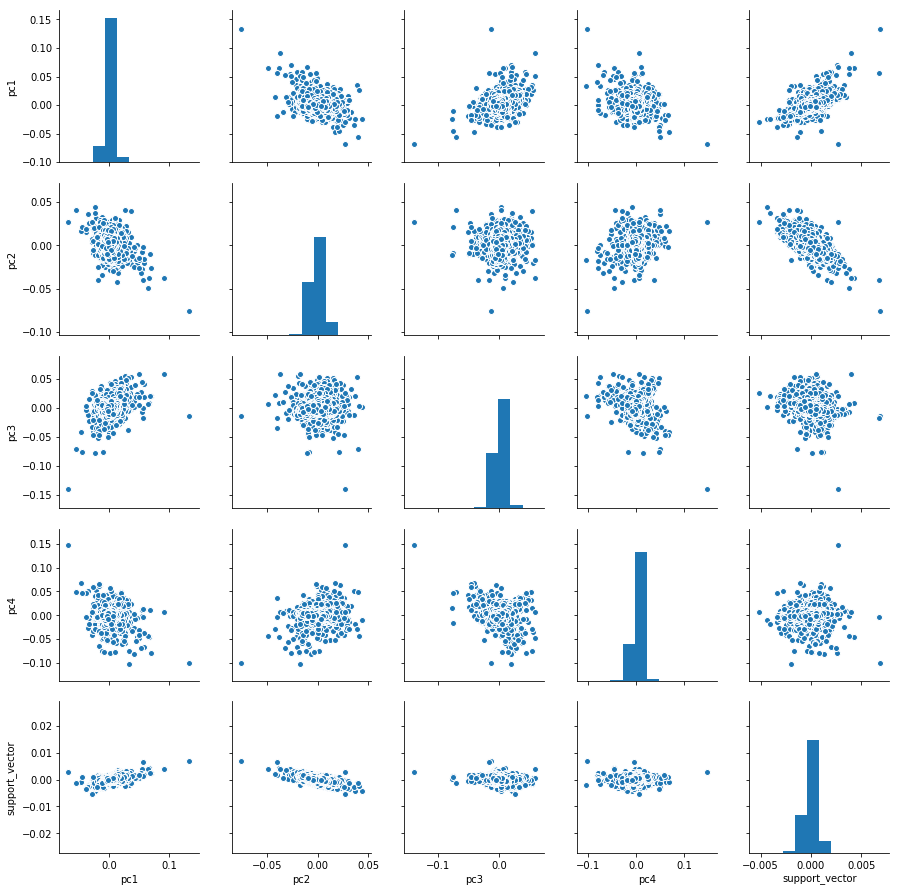

In [11]:
#Plot everything against everyother vector

pairplot = sns.pairplot(coeffs, vars = ['pc1', 'pc2', 'pc3', 'pc4', 'support_vector'])

The pairplot summarizes the regression plots between every component and the support vector. We see a very strong correlation between the first component and support vector, and a very strong negative correlation with the second component and the support vector. There is still a weaker negative correlation between the third component and the support vector.

We can also compute the correlation between the principal components and the support vector, and visualize them with a heatmap. This will verify our observations in the pairplot: Very strong correlation of the support vector with the first component, an also very strong but negative correlation with the second one and weaker but still measurable correlations between the support vector the the third and fourth component. 

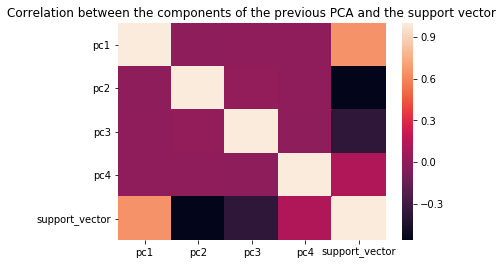

In [12]:
plt.title('Correlation between the components of the previous PCA and the support vector')

hmap = sns.heatmap(coeffs.corr())

### 1.4 Validate the model in a legitimate way
In 1.2 we asked you to evaluate the model with the same data you had trained it with. It's a poor and frowned upon way to test a model's accuracy, since you can't tell whether the model has merely memorized the exact inputs and expected outputs, or whether it truly found generalizable patterns in the data. The former scenario is often called *overfitting*.

This time, train the model with one half of the data, and validate its accuracy on the other half. Keep it simple for now, rows `::2` for training and `1::2` for validating should be good enough.

In [13]:
#Split datasets in two halfs
trainingdata = data[::2]
testdata = data[1::2]

trainingtarget = target[::2]
testtarget = target[1::2]


In [14]:
#Train the SVC with the first half
clf_validate = LinearSVC(random_state=0)
clf_validate.fit(trainingdata, trainingtarget)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)

In [15]:
#Predict on the second
clf_prediction = clf_validate.predict(testdata)
clf_validate.score(testdata, testtarget)

1.0

With half of the data for training and the other half for testing, the accuracy is still at 100%. 

### 1.4.2 Reduce the number of features
You may have found that the model still performs excellent, and it was successful at learning the structure of the data instead of just memorizing the training data. This a good sign, and it seems that it's no challenge for an SVM to distinguish the two diets from the full expression dataset. Let's make the SVM sweat a bit.

Try cutting down the number of used features until the point that validation is no longer fully accurate. Keep only every N-th feature (e.g. train and validate with data.iloc[::2,::N] and data.iloc[1::2, ::N]) until the model starts making mistakes. You can simply re-run the same jupyter cell with increasing N-s: we don't expect a graph or exhaustive measurements here, just find one big enough N that the accuracy isn't perfect anymore.

In [16]:
#Tried it out with various skips, but as we discussed in the end I took every 1800 feature
clf.fit(data.iloc[::2, ::1800], target.iloc[::2])

print('Accuracy from feature reduced model: '+ str(clf.score(data.iloc[1::2, ::1800], target.iloc[1::2], sample_weight=None)))

Accuracy from feature reduced model: 0.65


This one is a bit tricky. It is hard to tell where the turning point is because the feature selection can be lucky at get a few important features per chance, which have a bigger impackt than more but less important features. For example with keeping every 1000 feature produces a accuracy of 85%, while only keppeing every 2000 feature again is up to 90%. Kepping every 1800 feature for example let the accuarcy drop to 65%. In general the model will produce very good results as long the number of dimensions is at a similar height than the number of datapoints. If there are way more datapoints than the features the quality of the seperation will drop. 

### 1.5 Perform cross-validation
Previously you had separated your data into a disjoint training and testing set, trained the model with the training set and computed its accuracy on the testing set. But couldn't you switch them around, do it the other way, and compute a second accuracy value? The average of those two values would give you an even better estimate of the real accuracy. Indeed you could, and it would be called *2-fold cross-validation*.

3-fold cross-validation is when you split your data to D1/D2/D3 thirds, train the model with D1+D2 and test on D3. Then train with D1+D3 and test on D2, finally train with D2+D3 and test on D1. The average of the three accuracy values would be your model's 3-fold cross-validated accuracy.

(Sidenote: the *model* is the linear SVM with whatever default parameters it has, plus the features that you selected. During cross-validation you test different *instances* of the same model: you train them with different data so they will all end up slightly different, you test them with different data so the accuracy estimates will also be different, but you are validating the same *model* all along.)

`sklearn` gives you helper classes to split your data into training and testing sets following a cross-validation scheme, saving you most of the legwork. Some classes even support features like random shuffling, or stratification (keeping labels balanced across training/testing classes). Choose a simple one, and cross-validate your model on the restricted amount of features chosen in 1.4.2.

In [17]:
data_sparse = data.iloc[:, ::1800]

In [18]:
#Perform cross-validation manually because it is all about the journey and not about the destination.
cv = sm.StratifiedKFold(3, shuffle=True)

#Do it for every split
for training, test in cv.split(data_sparse, target):
    
    #Split the data accordingly
    data_sparse_train = data_sparse.iloc[training]
    data_sparse_test = data_sparse.iloc[test]
    
    target_train = target.iloc[training]
    target_test = target.iloc[test]
    
    #And to the training and testing on the respective partial datasets
    clf.fit(data_sparse_train, target_train)
    
    #The output is the accuracy for the SVM learned on every combination. To get an overall accuracy take the mean of this three values.
    print(clf.score(data_sparse_test, target_test))

0.75
0.7407407407407407
0.8076923076923077


Here it is important to use a 3-split when using vanilla kfold. Because of the binary nature of our data (either CD or HFD) with a default 2-split in the training part of the dataset there will only be 1 ( is_hfd) and in the test-data there will only be 0 (is not hfd = is CD). Using a 3-split will ensure that there are always 0's and 1's in both of the datasets. Alternatively it is possible to use a stratified KFold or use the shuffle function.

In [19]:
#OR do it pandas-style in one line with this 
#Compute mean of the individual accuracys of the different folds and this is the overall accuracy for the predictor
print('Accuracy of sparse model cross validated: '+ str((sm.cross_val_score(clf, data_sparse, target, \
                                                                 cv = sm.StratifiedKFold(3,shuffle=True))).mean()))

Accuracy of sparse model cross validated: 0.777981277981278
